In [1]:
import os

import numpy as np
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Import datasets

In [6]:
dir_csv = '../../data/bike_rental_history/raw'
list_csv = os.listdir(dir_csv)
unnecessary_columns = ['대여거치대', '반납거치대', '이용거리(M)', '이용시간(분)', '대여 대여소번호','반납대여소번호', '대여 대여소명', '반납대여소명']
dict_rename_columns={'자전거번호':'bike_id',
                     '대여일시':'rent_datetime',
                     '반납일시':'return_datetime',
                     '대여대여소ID':'origin_station_id',
                     '반납대여소ID':'desti_station_id',
                     '생년':'birth_year',
                     '이용자종류':'user_type',
                     '성별':'gender',
                     '자전거구분':'bike_type'}

# load holiday data
df_holiday = pd.read_csv('../../data/holidays.csv')
df_holiday.loc[:,'date'] = pd.to_datetime(df_holiday.loc[:,'year'].astype(str) +'-'+ df_holiday.loc[:,'month'].astype(str) +'-'+ df_holiday.loc[:,'day'].astype(str)).dt.date
df_holiday.loc[:,'date'] = df_holiday.loc[:,'date'].astype(str)
list_holiday = df_holiday.loc[:,'date'].unique().tolist()

## Merge datasets and drop some columns and values
list_df_bike = []
list_df_bike_weekday = []
list_df_bike_weekend = []
for csv in list_csv:
  df_tmp = pd.read_csv(f'{dir_csv}/{csv}', encoding='cp949')
  # drop the rows with missing values
  df_tmp = df_tmp.loc[np.logical_not(pd.isna(df_tmp.loc[:,'대여대여소ID']))]
  df_tmp = df_tmp.loc[np.logical_not(pd.isna(df_tmp.loc[:,'반납대여소ID']))]
  df_tmp = df_tmp.loc[np.logical_not(df_tmp.loc[:,'반납대여소ID'].str.contains('N'))]
  df_tmp.loc[:,'year'] = df_tmp.loc[:,'대여일시'].str[:4]
  df_tmp = df_tmp.loc[df_tmp.loc[:,'year'] == '2023']
  # drop unnecessary columns
  df_tmp = df_tmp.reset_index(drop=True).drop(columns=unnecessary_columns, axis=1)
  df_tmp = df_tmp.rename(columns=dict_rename_columns)
  df_tmp.loc[:,'rent_datetime'] = pd.to_datetime(df_tmp.loc[:,'rent_datetime'])
  df_tmp.loc[:,'return_datetime'] = pd.to_datetime(df_tmp.loc[:,'return_datetime'])
  # drop the rows with travel time > 30 minutes
  df_tmp = df_tmp.loc[(df_tmp.loc[:,'return_datetime'] - df_tmp.loc[:,'rent_datetime']).dt.total_seconds() <= 1800]
  df_tmp.loc[:,'weekday'] = pd.to_datetime(df_tmp.loc[:,'rent_datetime']).dt.weekday
  df_tmp.loc[:,'date'] = (pd.to_datetime(df_tmp.loc[:,'rent_datetime']).dt.date).astype(str)
  # split weekday and weekend (+ holiday)
  df_tmp_weekday = df_tmp.loc[np.logical_and(df_tmp.loc[:,'weekday'] < 5, ~df_tmp.loc[:,'date'].isin(list_holiday))]
  df_tmp_weekend = df_tmp.loc[np.logical_or(df_tmp.loc[:,'weekday'] >= 5, df_tmp.loc[:,'date'].isin(list_holiday))]
  # append the datasets
  list_df_bike.append(df_tmp)
  list_df_bike_weekday.append(df_tmp_weekday)
  list_df_bike_weekend.append(df_tmp_weekend)


# merge the imported datasets
df_bike_rental = pd.concat(list_df_bike, ignore_index=True)
df_bike_rental_weekday = pd.concat(list_df_bike_weekday, ignore_index=True)
df_bike_rental_weekend = pd.concat(list_df_bike_weekend, ignore_index=True)

In [7]:
df_bike_rental

,bike_id,rent_datetime,return_datetime,birth_year,gender,user_type,origin_station_id,desti_station_id,year,weekday,date,bike_type
0,SPB-39194,2023-01-01 00:02:13,2023-01-01 00:02:43,1977,\N,내국인,ST-2127,ST-2127,2023,6,2023-01-01,NaN
1,SPB-43457,2023-01-01 00:01:20,2023-01-01 00:03:28,1998,\N,내국인,ST-1121,ST-2699,2023,6,2023-01-01,NaN
2,SPB-44383,2023-01-01 00:04:01,2023-01-01 00:04:21,1993,M,내국인,ST-1590,ST-1590,2023,6,2023-01-01,NaN
3,SPB-37186,2023-01-01 00:02:09,2023-01-01 00:04:59,1965,M,내국인,ST-1841,ST-2740,2023,6,2023-01-01,NaN
4,SPB-59440,2023-01-01 00:02:24,2023-01-01 00:05:02,1986,M,내국인,ST-1215,ST-827,2023,6,2023-01-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36695289,SPB-59455,2023-12-31 23:54:53,2024-01-01 00:23:39,1991,M,내국인,ST-1274,ST-1274,2023,6,2023-12-31,일반자전거
36695290,SPB-31699,2023-12-31 23:57:24,2024-01-01 00:24:22,1985,\N,내국인,ST-1651,ST-2819,2023,6,2023-12-31,일반자전거
36695291,SPB-69751,2023-12-31 23:56:19,2024-01-01 00:25:30,1983,\N,내국인,ST-769,ST-1559,2023,6,2023-12-31,일반자전거
36695292,SPB-36733,2023-12-31 23:58:28,2024-01-01 00:27:33,1994,\N,내국인,ST-3137,ST-3146,2023,6,2023-12-31,일반자전거


In [8]:
df_bike_rental.to_csv('../../data/bike_rental_history/processed/2023_processed_entire.csv', index=False)
df_bike_rental_weekday.to_csv('../../data/bike_rental_history/processed/2023_processed_weekday.csv', index=False)
df_bike_rental_weekend.to_csv('../../data/bike_rental_history/processed/2023_processed_weekend.csv', index=False)

## Make a sample

In [7]:
df_bike_rental.sample(frac = 1/df_bike_rental.loc[:,'date'].nunique()).to_csv('../../data/bike_rental_history/processed_sample/2023_processed_entire_sample.csv', index=False)
df_bike_rental_weekday.sample(frac = 1/df_bike_rental_weekday.loc[:,'date'].nunique()).to_csv('../../data/bike_rental_history/processed_sample/2023_processed_weekday_sample.csv', index=False)
df_bike_rental_weekend.sample(frac = 1/df_bike_rental_weekend.loc[:,'date'].nunique()).to_csv('../../data/bike_rental_history/processed_sample/2023_processed_weekend_sample.csv', index=False)

## Aggregate the datasets

In [10]:
## truncate the rent_datetime by 30 minutes
df_bike_rental.loc[:,'rent_datetime_30min'] = df_bike_rental.loc[:,'rent_datetime'].dt.floor('30T')
df_bike_rental_agg = df_bike_rental.groupby(['rent_datetime_30min',
                                             'origin_station_id',
                                             'desti_station_id']).size().reset_index(name='count')

## weekday
df_bike_rental_weekday.loc[:,'rent_datetime_30min'] = df_bike_rental_weekday.loc[:,'rent_datetime'].dt.floor('30T')
df_bike_rental_weekday_agg = df_bike_rental_weekday.groupby(['rent_datetime_30min',
                                                             'origin_station_id',
                                                             'desti_station_id']).size().reset_index(name='count')

## weekend
df_bike_rental_weekend.loc[:,'rent_datetime_30min'] = df_bike_rental_weekend.loc[:,'rent_datetime'].dt.floor('30T')
df_bike_rental_weekend_agg = df_bike_rental_weekend.groupby(['rent_datetime_30min',
                                                             'origin_station_id',
                                                             'desti_station_id']).size().reset_index(name='count')

In [11]:
output_dir = '../../data/bike_rental_history/processed_30min_aggregated/'

df_bike_rental_agg.to_csv(f'{output_dir}2023_processed_entire_agg.csv', index=False)
df_bike_rental_weekday_agg.to_csv(f'{output_dir}2023_processed_weekday_agg.csv', index=False)
df_bike_rental_weekend_agg.to_csv(f'{output_dir}2023_processed_weekend_agg.csv', index=False)

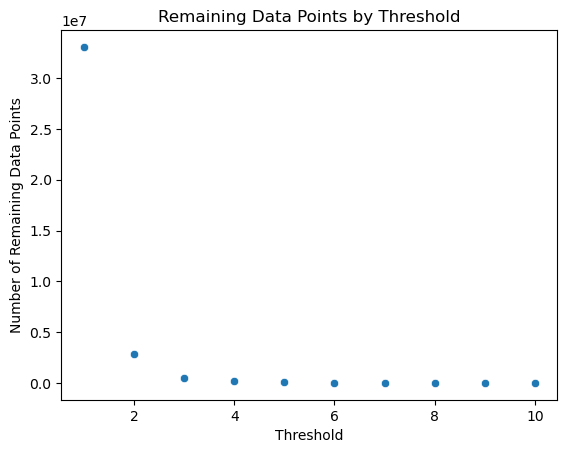

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

thresholds = range(1, 11)
remaining_data = []

for threshold in thresholds:
    filtered_df = df_bike_rental_agg[df_bike_rental_agg['count'] >= threshold]
    remaining_data.append(len(filtered_df))

sns.scatterplot(x=thresholds, y=remaining_data)
plt.xlabel('Threshold')
plt.ylabel('Number of Remaining Data Points')
plt.title('Remaining Data Points by Threshold')
plt.show()

In [23]:
threshold = 3
df_bike_rental_agg_filtered = df_bike_rental_agg[df_bike_rental_agg['count'] >= threshold]
df_bike_rental_weekday_agg_filtered = df_bike_rental_weekday_agg[df_bike_rental_weekday_agg['count'] >= threshold]
df_bike_rental_weekend_agg_filtered = df_bike_rental_weekend_agg[df_bike_rental_weekend_agg['count'] >= threshold]

df_bike_rental_agg_filtered.to_csv(f'{output_dir}2023_processed_entire_agg.csv', index=False)
df_bike_rental_weekday_agg_filtered.to_csv(f'{output_dir}2023_processed_weekday_agg.csv', index=False)
df_bike_rental_weekend_agg_filtered.to_csv(f'{output_dir}2023_processed_weekend_agg.csv', index=False)